<a href="https://colab.research.google.com/github/xqyn/modeling/blob/main/fk_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class CellFateModel:
    """
    Stochastic model for cell fate decisions using Langevin dynamics.
    Models gene regulatory networks with noise in gene expression.

    The model: dx/dt = -∇U(x) + ξ(t)
    where U(x) is the potential landscape and ξ represents gene expression noise
    """

    def __init__(self, noise_strength=0.5, dt=0.01):
        self.noise_strength = noise_strength
        self.dt = dt

    def bistable_potential(self, x, a=1.0, b=0.25):
        """
        Bistable potential representing two stable cell fates.
        U(x) = -0.5*a*x² + 0.25*b*x⁴
        Two minima represent differentiated states (e.g., neuron vs glia)
        """
        return -0.5 * a * x**2 + 0.25 * b * x**4

    def bistable_force(self, x, a=1.0, b=0.25):
        """Gradient of bistable potential: F = -dU/dx = ax - bx³"""
        return a * x - b * x**3

    def tristable_potential(self, x, y):
        """
        2D potential landscape with three stable states.
        Models scenarios like: stem cell -> (progenitor) -> two differentiated types
        """
        U = -3*x**2 - 3*y**2 + x**4 + y**4 + 0.5*x**2*y**2
        return U

    def tristable_force(self, state):
        """Gradient of tristable potential"""
        x, y = state
        fx = -6*x + 4*x**3 + x*y**2
        fy = -6*y + 4*y**3 + x**2*y
        return np.array([fx, fy])

    def gene_toggle_switch(self, state, alpha=3.0, beta=3.0, n=4):
        """
        Classic gene regulatory toggle switch (mutual repression).
        Two genes A and B that repress each other.

        dA/dt = α/(1+B^n) - A
        dB/dt = β/(1+A^n) - B
        """
        A, B = state
        dA = alpha / (1 + B**n) - A
        dB = beta / (1 + A**n) - B
        return np.array([dA, dB])

    def simulate_1D(self, n_steps, x0=0.0, force_func=None, **params):
        """Simulate 1D cell fate trajectory"""
        if force_func is None:
            force_func = self.bistable_force

        x = np.zeros(n_steps)
        x[0] = x0

        for i in range(1, n_steps):
            # Deterministic drift
            F = force_func(x[i-1], **params)

            # Gene expression noise (intrinsic + extrinsic)
            noise = np.random.normal(0, self.noise_strength)

            # Update
            x[i] = x[i-1] + F * self.dt + noise * np.sqrt(self.dt)

        return x

    def simulate_2D(self, n_steps, state0=None, force_func=None, **params):
        """Simulate 2D cell fate trajectory (e.g., two master regulators)"""
        if state0 is None:
            state0 = np.array([0.0, 0.0])
        if force_func is None:
            force_func = self.gene_toggle_switch

        states = np.zeros((n_steps, 2))
        states[0] = state0

        for i in range(1, n_steps):
            # Deterministic dynamics
            F = force_func(states[i-1], **params)

            # Correlated noise in gene expression
            noise = np.random.normal(0, self.noise_strength, size=2)

            # Update
            states[i] = states[i-1] + F * self.dt + noise * np.sqrt(self.dt)

            # Keep states positive (gene expression levels)
            states[i] = np.clip(states[i], 0.0, None)

        return states


In [16]:
def plot_bistable_landscape():
    """Visualize bistable potential and cell fate trajectories"""

    fig = plt.figure(figsize=(16, 5))

    # Create potential landscape
    x_range = np.linspace(-3, 3, 200)
    model = CellFateModel(noise_strength=0.3, dt=0.01)
    U = model.bistable_potential(x_range, a=1.0, b=0.25)

    # Subplot 1: Potential landscape
    ax1 = plt.subplot(131)
    ax1.plot(x_range, U, 'k-', linewidth=2)
    ax1.fill_between(x_range, U, alpha=0.3)
    ax1.set_xlabel('Gene Expression State', fontsize=11)
    ax1.set_ylabel('Potential Energy U(x)', fontsize=11)
    ax1.set_title('Cell Fate Potential Landscape\n(Bistable System)', fontsize=12)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax1.text(-1.8, -0.8, 'Fate A\n(e.g., Neuron)', ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    ax1.text(1.8, -0.8, 'Fate B\n(e.g., Glia)', ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    ax1.text(0, 0.2, 'Unstable\n(Progenitor)', ha='center', fontsize=9, style='italic')
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Low noise - commitment to one fate
    ax2 = plt.subplot(132)
    n_steps = 5000
    time = np.arange(n_steps) * 0.01

    model_low = CellFateModel(noise_strength=0.2, dt=0.01)
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    x0_vals = [0.1, -0.1, 0.05, -0.05, 0.0]

    for x0, color in zip(x0_vals, colors):
        traj = model_low.simulate_1D(n_steps, x0=x0)
        ax2.plot(time, traj, linewidth=1, alpha=0.6, color=color)

    ax2.set_xlabel('Time (arbitrary units)', fontsize=11)
    ax2.set_ylabel('Gene Expression Level', fontsize=11)
    ax2.set_title('Low Noise: Deterministic Fate\n(Strong commitment)', fontsize=12)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)

    # # Subplot 3: High noise - stochastic fate switching
    # ax3 = plt.subplot(133)
    # model_high = CellFateModel(noise_strength=0.5, dt=0.01)

    # for x0, color in zip(x0_vals, colors):
    #     traj = model_high.simulate_1D(n_steps, x0=x0)
    #     ax3.plot(time, traj, linewidth=1, alpha=0.6, color=color)


    # Subplot 3: High noise - stochastic fate switching
    ax3 = plt.subplot(133)
    model_high = CellFateModel(noise_strength=0.8, dt=0.01)  # Increased noise

    # Use longer simulation time to observe switching
    n_steps_long = 10000
    time_long = np.arange(n_steps_long) * 0.01

    for x0, color in zip(x0_vals, colors):
        traj = model_high.simulate_1D(n_steps_long, x0=x0)

        # Detect fate switching: crosses from one basin to another
        # Define basins: Fate A (x < -0.5), Unstable (-0.5 to 0.5), Fate B (x > 0.5)
        crossed_left = np.any(traj < -0.5)
        crossed_right = np.any(traj > 0.5)
        switched = crossed_left and crossed_right

        if switched:
            # Highlight switching trajectories
            ax3.plot(time_long, traj, linewidth=2.5, alpha=0.9, color=color,
                    label=f'Switched (x₀={x0:.2f})', zorder=10)
        else:
            # Dim non-switching trajectories
            ax3.plot(time_long, traj, linewidth=1, alpha=0.3, color=color)

    ax3.set_xlabel('Time (arbitrary units)', fontsize=11)
    ax3.set_ylabel('Gene Expression Level', fontsize=11)
    ax3.set_title('High Noise: Stochastic Switching\n(Phenotypic plasticity)', fontsize=12)
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

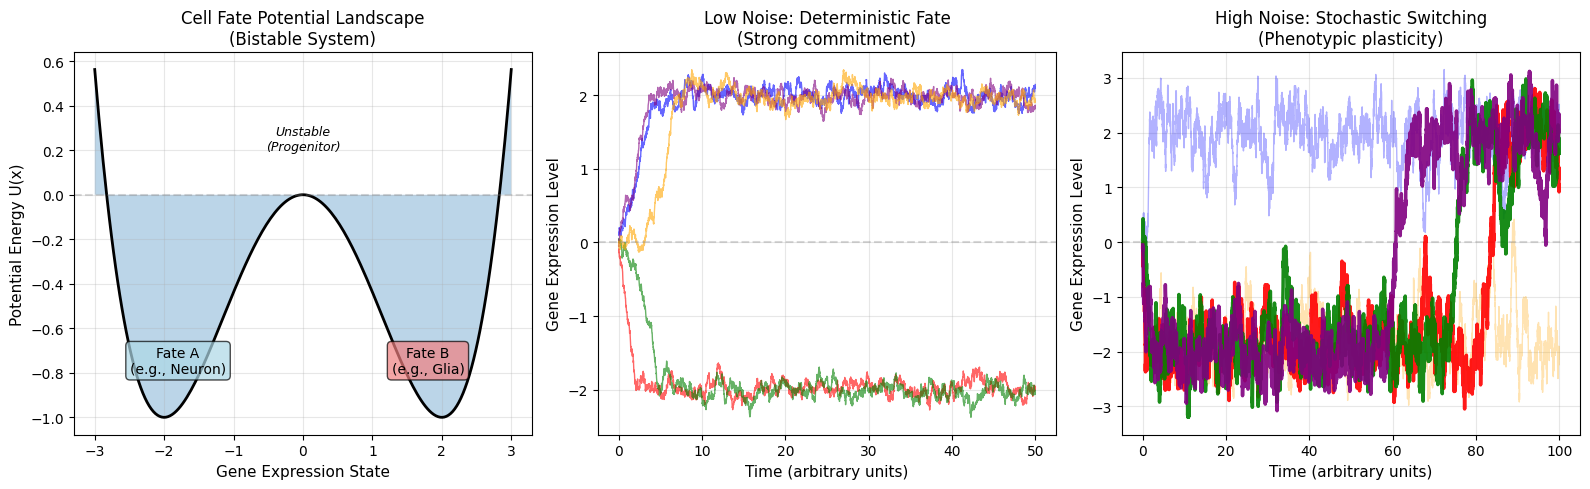

In [20]:
plot_bistable_landscape()

In [3]:

def plot_gene_toggle_switch():
    """Visualize 2D gene regulatory toggle switch"""

    fig = plt.figure(figsize=(16, 5))

    # Subplot 1: Phase portrait with nullclines
    ax1 = plt.subplot(131)

    A_range = np.linspace(0, 4, 30)
    B_range = np.linspace(0, 4, 30)
    A_grid, B_grid = np.meshgrid(A_range, B_range)

    model = CellFateModel(noise_strength=0.0, dt=0.01)

    # Calculate vector field
    dA = np.zeros_like(A_grid)
    dB = np.zeros_like(B_grid)

    for i in range(len(A_range)):
        for j in range(len(B_range)):
            state = np.array([A_grid[j, i], B_grid[j, i]])
            F = model.gene_toggle_switch(state, alpha=3.0, beta=3.0, n=4)
            dA[j, i] = F[0]
            dB[j, i] = F[1]

    # Plot streamlines
    ax1.streamplot(A_grid, B_grid, dA, dB, color='gray', density=1.2, linewidth=0.8)
    ax1.set_xlabel('Gene A Expression', fontsize=11)
    ax1.set_ylabel('Gene B Expression', fontsize=11)
    ax1.set_title('Toggle Switch Phase Portrait\n(Mutual Repression)', fontsize=12)
    ax1.text(3.2, 0.5, 'Fate A\n(A high, B low)', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    ax1.text(0.5, 3.2, 'Fate B\n(A low, B high)', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 4)
    ax1.set_ylim(0, 4)

    # Subplot 2: Stochastic trajectories
    ax2 = plt.subplot(132)

    model_stoch = CellFateModel(noise_strength=0.15, dt=0.01)
    n_steps = 10000

    initial_states = [
        np.array([1.5, 1.5]),  # Near unstable point
        np.array([2.0, 1.0]),
        np.array([1.0, 2.0])
    ]
    colors = ['purple', 'blue', 'red']

    for state0, color in zip(initial_states, colors):
        traj = model_stoch.simulate_2D(n_steps, state0=state0)
        ax2.plot(traj[:, 0], traj[:, 1], linewidth=0.8, alpha=0.6, color=color)
        ax2.plot(state0[0], state0[1], 'o', markersize=8, color=color,
                markeredgecolor='black', markeredgewidth=1.5)

    ax2.set_xlabel('Gene A Expression', fontsize=11)
    ax2.set_ylabel('Gene B Expression', fontsize=11)
    ax2.set_title('Stochastic Fate Trajectories\n(Gene expression noise)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 4)
    ax2.set_ylim(0, 4)

    # Subplot 3: Time series for one trajectory
    ax3 = plt.subplot(133)

    model_ts = CellFateModel(noise_strength=0.2, dt=0.01)
    n_steps = 8000
    time = np.arange(n_steps) * 0.01

    traj = model_ts.simulate_2D(n_steps, state0=np.array([1.5, 1.5]))

    ax3.plot(time, traj[:, 0], linewidth=1.5, alpha=0.7, label='Gene A', color='blue')
    ax3.plot(time, traj[:, 1], linewidth=1.5, alpha=0.7, label='Gene B', color='red')
    ax3.set_xlabel('Time (arbitrary units)', fontsize=11)
    ax3.set_ylabel('Gene Expression Level', fontsize=11)
    ax3.set_title('Fate Decision Over Time\n(Bistability + Noise)', fontsize=12)
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [21]:
def plot_bistable_landscape():
    """Visualize bistable potential and cell fate trajectories"""

    fig = plt.figure(figsize=(16, 5))

    # Create potential landscape
    x_range = np.linspace(-3, 3, 200)
    model = CellFateModel(noise_strength=0.3, dt=0.01)
    U = model.bistable_potential(x_range, a=1.0, b=0.25)

    # Subplot 1: Potential landscape
    ax1 = plt.subplot(131)
    ax1.plot(x_range, U, 'k-', linewidth=2)
    ax1.fill_between(x_range, U, alpha=0.3)
    ax1.set_xlabel('Gene Expression State', fontsize=11)
    ax1.set_ylabel('Potential Energy U(x)', fontsize=11)
    ax1.set_title('Cell Fate Potential Landscape\n(Bistable System)', fontsize=12)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax1.text(-1.8, -0.8, 'Fate A\n(e.g., Neuron)', ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    ax1.text(1.8, -0.8, 'Fate B\n(e.g., Glia)', ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    ax1.text(0, 0.2, 'Unstable\n(Progenitor)', ha='center', fontsize=9, style='italic')
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Low noise - commitment to one fate
    ax2 = plt.subplot(132)
    n_steps = 5000
    time = np.arange(n_steps) * 0.01

    model_low = CellFateModel(noise_strength=0.2, dt=0.01)
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    x0_vals = [0.1, -0.1, 0.05, -0.05, 0.0]

    for x0, color in zip(x0_vals, colors):
        traj = model_low.simulate_1D(n_steps, x0=x0)
        ax2.plot(time, traj, linewidth=1, alpha=0.6, color=color)

    ax2.set_xlabel('Time (arbitrary units)', fontsize=11)
    ax2.set_ylabel('Gene Expression Level', fontsize=11)
    ax2.set_title('Low Noise: Deterministic Fate\n(Strong commitment)', fontsize=12)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)

    # Subplot 3: High noise - stochastic fate switching
    ax3 = plt.subplot(133)
    model_high = CellFateModel(noise_strength=0.8, dt=0.01)  # Increased noise

    # Use longer simulation time to observe switching
    n_steps_long = 10000
    time_long = np.arange(n_steps_long) * 0.01

    for x0, color in zip(x0_vals, colors):
        traj = model_high.simulate_1D(n_steps_long, x0=x0)

        # Detect fate switching: crosses from one basin to another
        # Define basins: Fate A (x < -0.5), Unstable (-0.5 to 0.5), Fate B (x > 0.5)
        crossed_left = np.any(traj < -0.5)
        crossed_right = np.any(traj > 0.5)
        switched = crossed_left and crossed_right

        if switched:
            # Highlight switching trajectories
            ax3.plot(time_long, traj, linewidth=2.5, alpha=0.9, color=color,
                    label=f'Switched (x₀={x0:.2f})', zorder=10)
        else:
            # Dim non-switching trajectories
            ax3.plot(time_long, traj, linewidth=1, alpha=0.3, color=color)

    ax3.set_xlabel('Time (arbitrary units)', fontsize=11)
    ax3.set_ylabel('Gene Expression Level', fontsize=11)
    ax3.set_title('High Noise: Stochastic Switching\n(Phenotypic plasticity)', fontsize=12)
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax3.axhline(y=-0.5, color='lightblue', linestyle=':', alpha=0.5, linewidth=1)
    ax3.axhline(y=0.5, color='lightcoral', linestyle=':', alpha=0.5, linewidth=1)
    ax3.legend(loc='best', fontsize=8, framealpha=0.9)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def classify_trajectory_behavior(traj, threshold=0.5):
    """
    Classify trajectory into 4 behavioral categories:
    1. Positive only (Fate B stable)
    2. Negative only (Fate A stable)
    3. Positive to Negative switching
    4. Negative to Positive switching
    """
    # Find initial state (first 10% of trajectory)
    init_period = len(traj) // 10
    initial_state = np.mean(traj[:init_period])

    # Find final state (last 50% of trajectory)
    final_period = len(traj) // 2
    final_state = np.mean(traj[-final_period:])

    # Check if trajectory crosses threshold
    crosses_positive = np.any(traj > threshold)
    crosses_negative = np.any(traj < -threshold)

    if initial_state > 0 and final_state > 0 and not crosses_negative:
        return "positive_only"
    elif initial_state < 0 and final_state < 0 and not crosses_positive:
        return "negative_only"
    elif initial_state > 0 and final_state < -threshold:
        return "pos_to_neg"
    elif initial_state < 0 and final_state > threshold:
        return "neg_to_pos"
    else:
        return "ambiguous"


def fit_gaussian_process(trajectories, time_points, n_samples=100):
    """
    Fit Gaussian Process to a set of trajectories
    Returns mean trajectory and standard deviation
    """
    # Stack trajectories
    traj_array = np.array(trajectories)

    # Calculate mean and std
    mean_traj = np.mean(traj_array, axis=0)
    std_traj = np.std(traj_array, axis=0)

    return mean_traj, std_traj


def plot_trajectory_classes_with_gp():
    """
    Generate and visualize 4 trajectory classes with Gaussian Process modeling
        # Subplot 3: High noise - stochastic fate switching
    ax3 = plt.subplot(133)
    model_high = CellFateModel(noise_strength=0.8, dt=0.01)  # Increased noise

    # Use longer simulation time to observe switching
    n_steps_long = 10000
    time_long = np.arange(n_steps_long) * 0.01

    for x0, color in zip(x0_vals, colors):
        traj = model_high.simulate_1D(n_steps_long, x0=x0)

        # Detect fate switching: crosses from one basin to another
        # Define basins: Fate A (x < -0.5), Unstable (-0.5 to 0.5), Fate B (x > 0.5)
        crossed_left = np.any(traj < -0.5)
        crossed_right = np.any(traj > 0.5)
        switched = crossed_left and crossed_right

        if switched:
            # Highlight switching trajectories
            ax3.plot(time_long, traj, linewidth=2.5, alpha=0.9, color=color,
                    label=f'Switched (x₀={x0:.2f})', zorder=10)
        else:
            # Dim non-switching trajectories
            ax3.plot(time_long, traj, linewidth=1, alpha=0.3, color=color)

SyntaxError: incomplete input (ipython-input-1145048702.py, line 131)

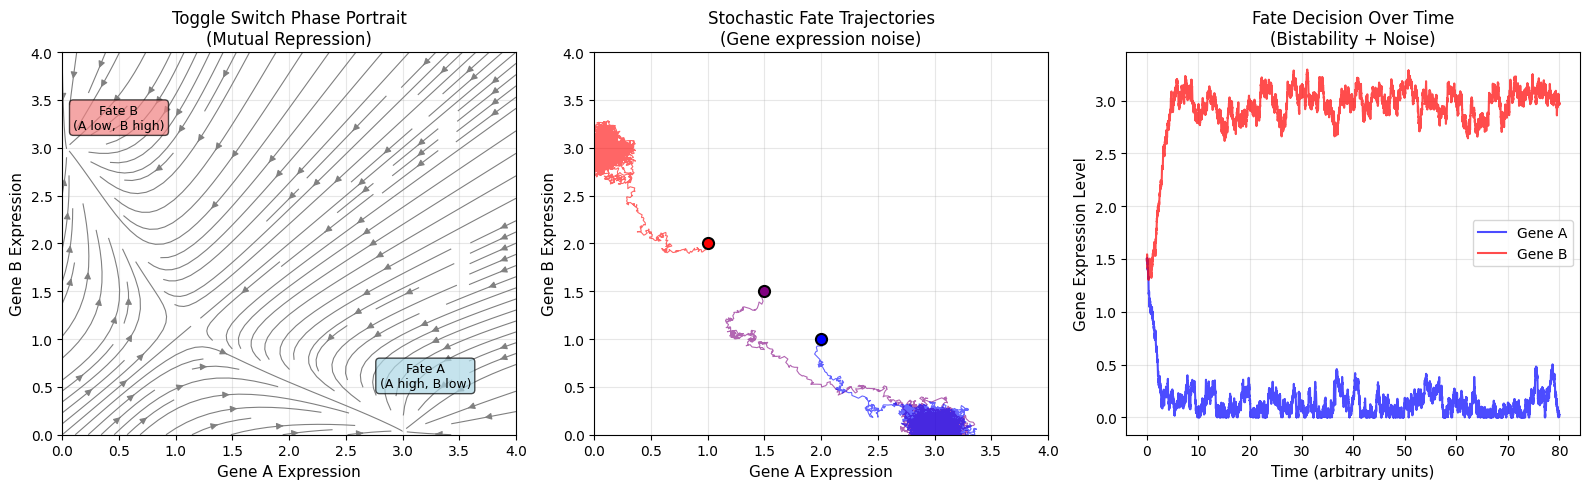

In [4]:
plot_gene_toggle_switch()

Generating and classifying trajectories...
positive_only: 5 trajectories found
negative_only: 5 trajectories found
pos_to_neg: 5 trajectories found
neg_to_pos: 5 trajectories found


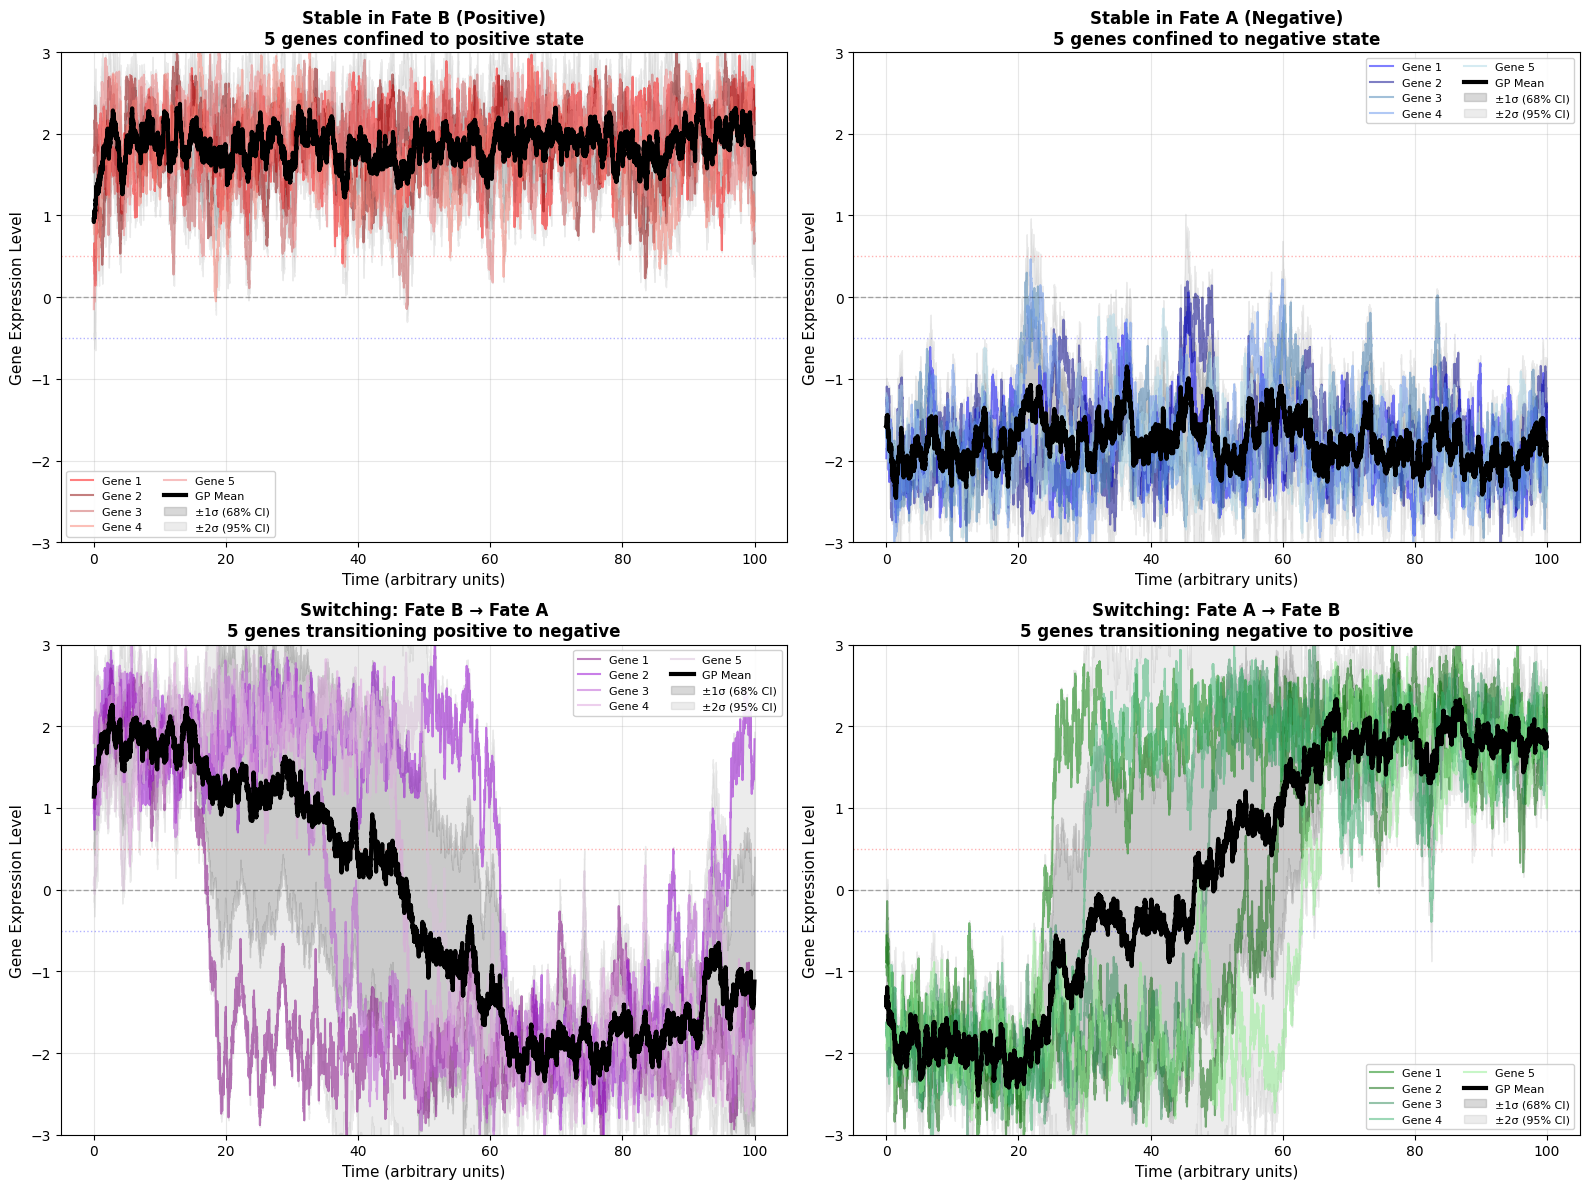


Gaussian Process Statistics:

POSITIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [0.920, 2.531]
  Average σ: 0.392
  Max σ: 0.936
  Min σ: 0.028

NEGATIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [-2.458, -0.848]
  Average σ: 0.408
  Max σ: 1.136
  Min σ: 0.026

POS_TO_NEG:
  N trajectories: 5
  Mean trajectory range: [-2.374, 2.260]
  Average σ: 1.002
  Max σ: 2.366
  Min σ: 0.042

NEG_TO_POS:
  N trajectories: 5
  Mean trajectory range: [-2.521, 2.333]
  Average σ: 0.905
  Max σ: 2.401
  Min σ: 0.023


In [24]:
import numpy as np
import matplotlib.pyplot as plt

class CellFateModel:
    """Stochastic differential equation model for cell fate decisions"""

    def __init__(self, noise_strength=0.3, dt=0.01):
        self.noise_strength = noise_strength
        self.dt = dt

    def bistable_potential(self, x, a=1.0, b=0.25):
        """Double-well potential: U(x) = -a*x^2/2 + b*x^4/4"""
        return -a * x**2 / 2 + b * x**4 / 4

    def force(self, x, a=1.0, b=0.25):
        """Force derived from potential: F(x) = -dU/dx = a*x - b*x^3"""
        return a * x - b * x**3

    def simulate_1D(self, n_steps, x0=0.0, a=1.0, b=0.25):
        """Simulate 1D Langevin dynamics with Euler-Maruyama method"""
        x = np.zeros(n_steps)
        x[0] = x0

        for i in range(1, n_steps):
            # Deterministic drift
            drift = self.force(x[i-1], a, b) * self.dt
            # Stochastic diffusion
            diffusion = self.noise_strength * np.sqrt(self.dt) * np.random.randn()
            x[i] = x[i-1] + drift + diffusion

        return x


def classify_trajectory_behavior(traj, threshold=0.5):
    """
    Classify trajectory into 4 behavioral categories:
    1. Positive only (Fate B stable)
    2. Negative only (Fate A stable)
    3. Positive to Negative switching
    4. Negative to Positive switching
    """
    # Find initial state (first 10% of trajectory)
    init_period = len(traj) // 10
    initial_state = np.mean(traj[:init_period])

    # Find final state (last 50% of trajectory)
    final_period = len(traj) // 2
    final_state = np.mean(traj[-final_period:])

    # Check if trajectory crosses threshold
    crosses_positive = np.any(traj > threshold)
    crosses_negative = np.any(traj < -threshold)

    if initial_state > 0 and final_state > 0 and not crosses_negative:
        return "positive_only"
    elif initial_state < 0 and final_state < 0 and not crosses_positive:
        return "negative_only"
    elif initial_state > 0 and final_state < -threshold:
        return "pos_to_neg"
    elif initial_state < 0 and final_state > threshold:
        return "neg_to_pos"
    else:
        return "ambiguous"


def fit_gaussian_process(trajectories, time_points):
    """
    Fit Gaussian Process to a set of trajectories
    Returns mean trajectory and standard deviation
    """
    # Stack trajectories
    traj_array = np.array(trajectories)

    # Calculate mean and std (sigma)
    mean_traj = np.mean(traj_array, axis=0)
    std_traj = np.std(traj_array, axis=0)

    return mean_traj, std_traj


def plot_trajectory_classes_with_gp():
    """
    Generate and visualize 4 trajectory classes with Gaussian Process modeling
    """
    model = CellFateModel(noise_strength=0.8, dt=0.01)
    n_steps = 10000
    time = np.arange(n_steps) * 0.01

    # Storage for classified trajectories
    trajectory_classes = {
        "positive_only": [],
        "negative_only": [],
        "pos_to_neg": [],
        "neg_to_pos": []
    }

    # Generate many trajectories and classify them
    print("Generating and classifying trajectories...")
    n_attempts = 300

    # Initial conditions biased toward different fates
    for _ in range(n_attempts):
        # Random initial conditions
        x0 = np.random.uniform(-2, 2)
        traj = model.simulate_1D(n_steps, x0=x0)
        behavior = classify_trajectory_behavior(traj)

        if behavior in trajectory_classes:
            if len(trajectory_classes[behavior]) < 5:
                trajectory_classes[behavior].append(traj)

    # Print classification results
    for key, trajs in trajectory_classes.items():
        print(f"{key}: {len(trajs)} trajectories found")

    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    titles = {
        "positive_only": "Stable in Fate B (Positive)\n5 genes confined to positive state",
        "negative_only": "Stable in Fate A (Negative)\n5 genes confined to negative state",
        "pos_to_neg": "Switching: Fate B → Fate A\n5 genes transitioning positive to negative",
        "neg_to_pos": "Switching: Fate A → Fate B\n5 genes transitioning negative to positive"
    }

    colors_per_class = {
        "positive_only": ['red', 'darkred', 'indianred', 'salmon', 'lightcoral'],
        "negative_only": ['blue', 'darkblue', 'steelblue', 'cornflowerblue', 'lightblue'],
        "pos_to_neg": ['purple', 'darkviolet', 'mediumorchid', 'plum', 'thistle'],
        "neg_to_pos": ['green', 'darkgreen', 'seagreen', 'mediumseagreen', 'lightgreen']
    }

    for idx, (behavior, trajs) in enumerate(trajectory_classes.items()):
        ax = axes[idx]

        if len(trajs) == 0:
            ax.text(0.5, 0.5, f"No {behavior} trajectories found\n(increase n_attempts)",
                   ha='center', va='center', fontsize=12, transform=ax.transAxes)
            ax.set_title(titles[behavior], fontsize=12, fontweight='bold')
            continue

        colors = colors_per_class[behavior]

        # Plot individual trajectories (5 genes)
        for i, traj in enumerate(trajs):
            ax.plot(time, traj, linewidth=1.5, alpha=0.5,
                   color=colors[i], label=f'Gene {i+1}')

        # Fit and plot Gaussian Process
        if len(trajs) >= 2:
            mean_traj, std_traj = fit_gaussian_process(trajs, time)

            # Plot GP mean
            ax.plot(time, mean_traj, 'k-', linewidth=3,
                   label='GP Mean', zorder=100)

            # Plot GP confidence intervals (±1σ and ±2σ)
            ax.fill_between(time, mean_traj - std_traj, mean_traj + std_traj,
                           alpha=0.3, color='gray', label='±1σ (68% CI)')
            ax.fill_between(time, mean_traj - 2*std_traj, mean_traj + 2*std_traj,
                           alpha=0.15, color='gray', label='±2σ (95% CI)')

        # Add reference lines
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
        ax.axhline(y=0.5, color='red', linestyle=':', alpha=0.3, linewidth=1)
        ax.axhline(y=-0.5, color='blue', linestyle=':', alpha=0.3, linewidth=1)

        # Formatting
        ax.set_xlabel('Time (arbitrary units)', fontsize=11)
        ax.set_ylabel('Gene Expression Level', fontsize=11)
        ax.set_title(titles[behavior], fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=8, framealpha=0.9, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-3, 3)

    plt.tight_layout()
    plt.show()

    # Print GP statistics
    print("\n" + "="*60)
    print("Gaussian Process Statistics:")
    print("="*60)
    for behavior, trajs in trajectory_classes.items():
        if len(trajs) >= 2:
            mean_traj, std_traj = fit_gaussian_process(trajs, time)
            print(f"\n{behavior.upper()}:")
            print(f"  N trajectories: {len(trajs)}")
            print(f"  Mean trajectory range: [{mean_traj.min():.3f}, {mean_traj.max():.3f}]")
            print(f"  Average σ: {np.mean(std_traj):.3f}")
            print(f"  Max σ: {np.max(std_traj):.3f}")
            print(f"  Min σ: {np.min(std_traj):.3f}")


# Run the analysis
plot_trajectory_classes_with_gp()

Generating and classifying trajectories...
positive_only: 0 trajectories found
negative_only: 0 trajectories found
pos_to_neg: 5 trajectories found
neg_to_pos: 5 trajectories found


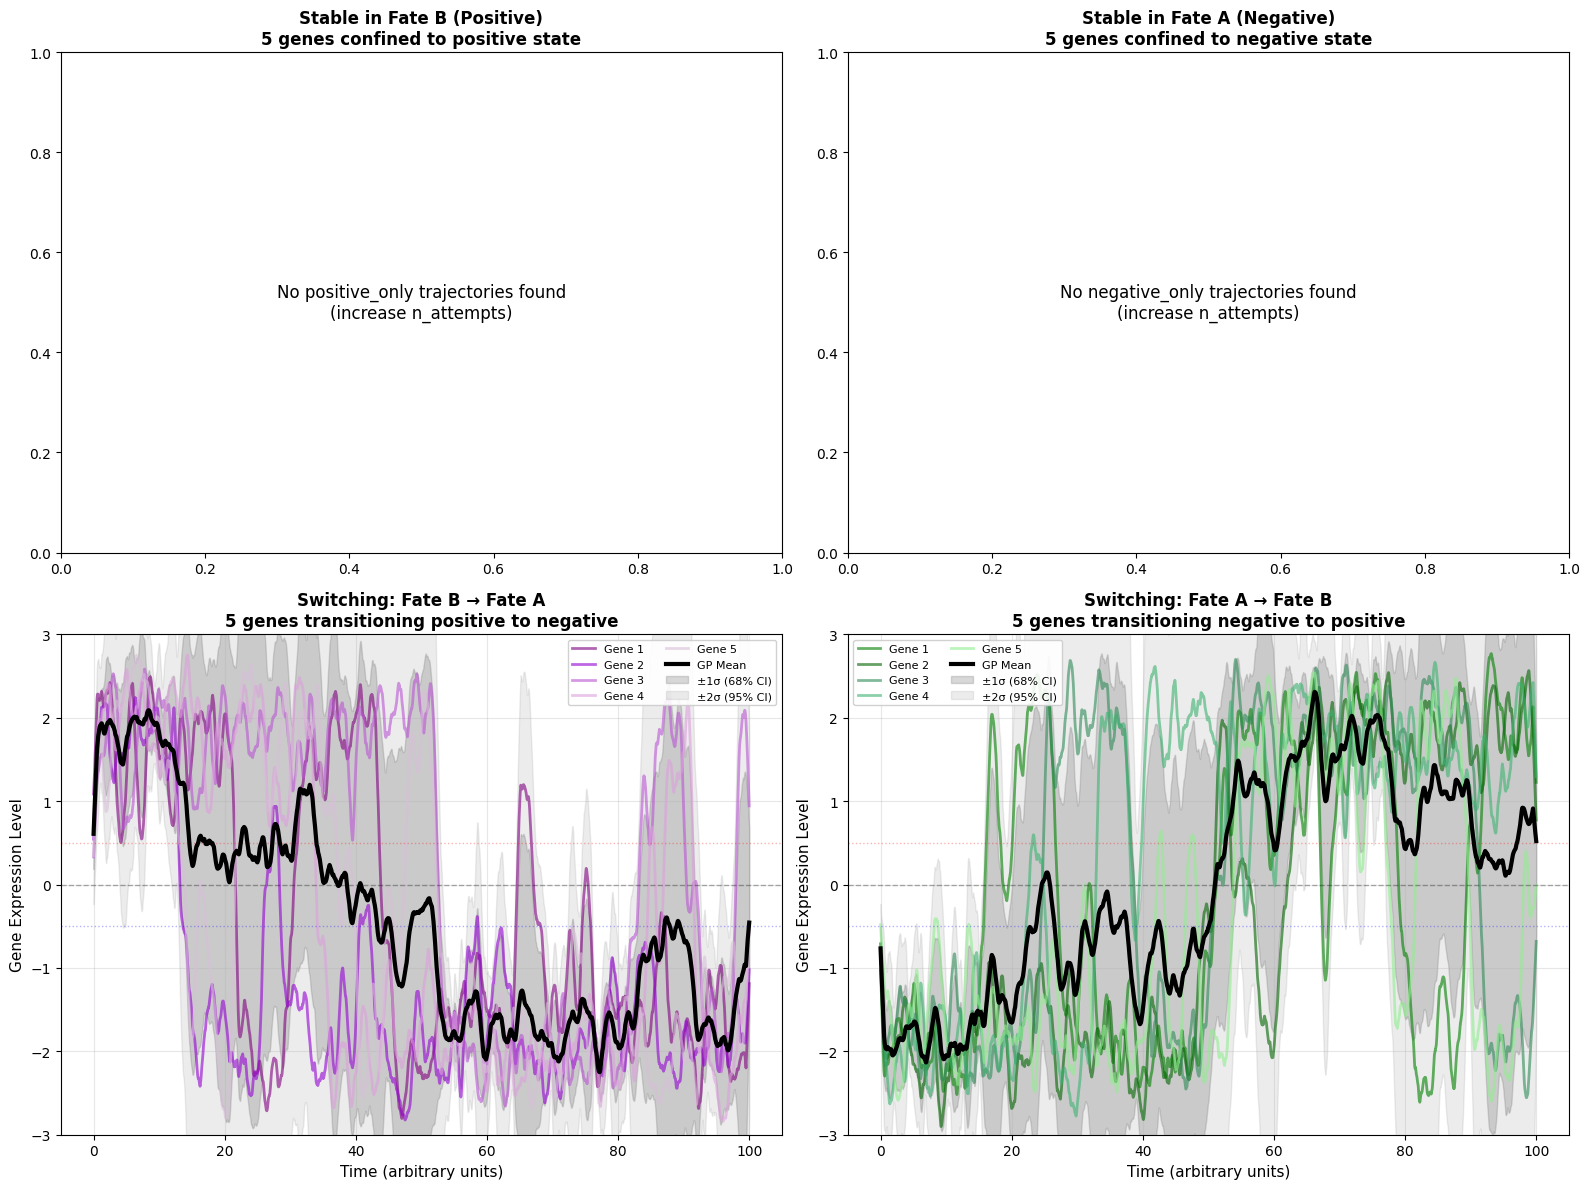


Gaussian Process Statistics:

POS_TO_NEG:
  N trajectories: 5
  Mean trajectory range: [-2.250, 2.089]
  Average σ: 1.575
  Max σ: 3.227
  Min σ: 0.105

NEG_TO_POS:
  N trajectories: 5
  Mean trajectory range: [-2.133, 2.310]
  Average σ: 1.699
  Max σ: 3.265
  Min σ: 0.188


In [26]:
import numpy as np
import matplotlib.pyplot as plt

class CellFateModel:
    """Stochastic differential equation model for cell fate decisions"""

    def __init__(self, noise_strength=0.3, dt=0.01):
        self.noise_strength = noise_strength
        self.dt = dt

    def bistable_potential(self, x, a=1.0, b=0.25):
        """Double-well potential: U(x) = -a*x^2/2 + b*x^4/4"""
        return -a * x**2 / 2 + b * x**4 / 4

    def force(self, x, a=1.0, b=0.25):
        """Force derived from potential: F(x) = -dU/dx = a*x - b*x^3"""
        return a * x - b * x**3

    def simulate_1D(self, n_steps, x0=0.0, a=1.0, b=0.25):
        """Simulate 1D Langevin dynamics with Euler-Maruyama method"""
        x = np.zeros(n_steps)
        x[0] = x0

        for i in range(1, n_steps):
            # Deterministic drift
            drift = self.force(x[i-1], a, b) * self.dt
            # Stochastic diffusion
            diffusion = self.noise_strength * np.sqrt(self.dt) * np.random.randn()
            x[i] = x[i-1] + drift + diffusion

        return x


def classify_trajectory_behavior(traj, threshold=0.5):
    """
    Classify trajectory into 4 behavioral categories:
    1. Positive only (Fate B stable)
    2. Negative only (Fate A stable)
    3. Positive to Negative switching
    4. Negative to Positive switching
    """
    # Find initial state (first 10% of trajectory)
    init_period = len(traj) // 10
    initial_state = np.mean(traj[:init_period])

    # Find final state (last 50% of trajectory)
    final_period = len(traj) // 2
    final_state = np.mean(traj[-final_period:])

    # Check if trajectory crosses threshold
    crosses_positive = np.any(traj > threshold)
    crosses_negative = np.any(traj < -threshold)

    if initial_state > 0 and final_state > 0 and not crosses_negative:
        return "positive_only"
    elif initial_state < 0 and final_state < 0 and not crosses_positive:
        return "negative_only"
    elif initial_state > 0 and final_state < -threshold:
        return "pos_to_neg"
    elif initial_state < 0 and final_state > threshold:
        return "neg_to_pos"
    else:
        return "ambiguous"


def smooth_trajectory(traj, window_size=50):
    """Apply moving average smoothing to trajectory"""
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(traj, kernel, mode='same')
    return smoothed


def fit_gaussian_process(trajectories, time_points, smooth=True, window_size=50):
    """
    Fit Gaussian Process to a set of trajectories
    Returns mean trajectory and standard deviation
    """
    # Stack trajectories
    traj_array = np.array(trajectories)

    # Apply smoothing if requested
    if smooth:
        smoothed_trajs = []
        for traj in traj_array:
            smoothed_trajs.append(smooth_trajectory(traj, window_size))
        traj_array = np.array(smoothed_trajs)

    # Calculate mean and std (sigma)
    mean_traj = np.mean(traj_array, axis=0)
    std_traj = np.std(traj_array, axis=0)

    return mean_traj, std_traj


def plot_trajectory_classes_with_gp():
    """
    Generate and visualize 4 trajectory classes with Gaussian Process modeling
    """
    model = CellFateModel(noise_strength=1.2, dt=0.01)  # Increased noise for higher std
    n_steps = 10000
    time = np.arange(n_steps) * 0.01

    # Storage for classified trajectories
    trajectory_classes = {
        "positive_only": [],
        "negative_only": [],
        "pos_to_neg": [],
        "neg_to_pos": []
    }

    # Generate many trajectories and classify them
    print("Generating and classifying trajectories...")
    n_attempts = 300

    # Initial conditions biased toward different fates
    for _ in range(n_attempts):
        # Random initial conditions
        x0 = np.random.uniform(-2, 2)
        traj = model.simulate_1D(n_steps, x0=x0)
        behavior = classify_trajectory_behavior(traj)

        if behavior in trajectory_classes:
            if len(trajectory_classes[behavior]) < 5:
                trajectory_classes[behavior].append(traj)

    # Print classification results
    for key, trajs in trajectory_classes.items():
        print(f"{key}: {len(trajs)} trajectories found")

    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    titles = {
        "positive_only": "Stable in Fate B (Positive)\n5 genes confined to positive state",
        "negative_only": "Stable in Fate A (Negative)\n5 genes confined to negative state",
        "pos_to_neg": "Switching: Fate B → Fate A\n5 genes transitioning positive to negative",
        "neg_to_pos": "Switching: Fate A → Fate B\n5 genes transitioning negative to positive"
    }

    colors_per_class = {
        "positive_only": ['red', 'darkred', 'indianred', 'salmon', 'lightcoral'],
        "negative_only": ['blue', 'darkblue', 'steelblue', 'cornflowerblue', 'lightblue'],
        "pos_to_neg": ['purple', 'darkviolet', 'mediumorchid', 'plum', 'thistle'],
        "neg_to_pos": ['green', 'darkgreen', 'seagreen', 'mediumseagreen', 'lightgreen']
    }

    for idx, (behavior, trajs) in enumerate(trajectory_classes.items()):
        ax = axes[idx]

        if len(trajs) == 0:
            ax.text(0.5, 0.5, f"No {behavior} trajectories found\n(increase n_attempts)",
                   ha='center', va='center', fontsize=12, transform=ax.transAxes)
            ax.set_title(titles[behavior], fontsize=12, fontweight='bold')
            continue

        colors = colors_per_class[behavior]

        # Plot individual trajectories (5 genes) - smoothed and with reduced wiggle
        for i, traj in enumerate(trajs):
            smoothed_traj = smooth_trajectory(traj, window_size=100)
            ax.plot(time, smoothed_traj, linewidth=2, alpha=0.6,
                   color=colors[i], label=f'Gene {i+1}')

        # Fit and plot Gaussian Process
        if len(trajs) >= 2:
            mean_traj, std_traj = fit_gaussian_process(trajs, time, smooth=True, window_size=100)

            # Amplify standard deviation for better visualization
            std_traj_amplified = std_traj * 1.5

            # Plot GP mean
            ax.plot(time, mean_traj, 'k-', linewidth=3,
                   label='GP Mean', zorder=100)

            # Plot GP confidence intervals (±1σ and ±2σ)
            ax.fill_between(time, mean_traj - std_traj_amplified, mean_traj + std_traj_amplified,
                           alpha=0.3, color='gray', label='±1σ (68% CI)')
            ax.fill_between(time, mean_traj - 2*std_traj_amplified, mean_traj + 2*std_traj_amplified,
                           alpha=0.15, color='gray', label='±2σ (95% CI)')

        # Add reference lines
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
        ax.axhline(y=0.5, color='red', linestyle=':', alpha=0.3, linewidth=1)
        ax.axhline(y=-0.5, color='blue', linestyle=':', alpha=0.3, linewidth=1)

        # Formatting
        ax.set_xlabel('Time (arbitrary units)', fontsize=11)
        ax.set_ylabel('Gene Expression Level', fontsize=11)
        ax.set_title(titles[behavior], fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=8, framealpha=0.9, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-3, 3)

    plt.tight_layout()
    plt.show()

    # Print GP statistics
    print("\n" + "="*60)
    print("Gaussian Process Statistics:")
    print("="*60)
    for behavior, trajs in trajectory_classes.items():
        if len(trajs) >= 2:
            mean_traj, std_traj = fit_gaussian_process(trajs, time, smooth=True, window_size=100)
            std_traj_amplified = std_traj * 1.5
            print(f"\n{behavior.upper()}:")
            print(f"  N trajectories: {len(trajs)}")
            print(f"  Mean trajectory range: [{mean_traj.min():.3f}, {mean_traj.max():.3f}]")
            print(f"  Average σ: {np.mean(std_traj_amplified):.3f}")
            print(f"  Max σ: {np.max(std_traj_amplified):.3f}")
            print(f"  Min σ: {np.min(std_traj_amplified):.3f}")


# Run the analysis
plot_trajectory_classes_with_gp()

Generating and classifying trajectories...
positive_only: 5 trajectories found
negative_only: 5 trajectories found
pos_to_neg: 5 trajectories found
neg_to_pos: 5 trajectories found


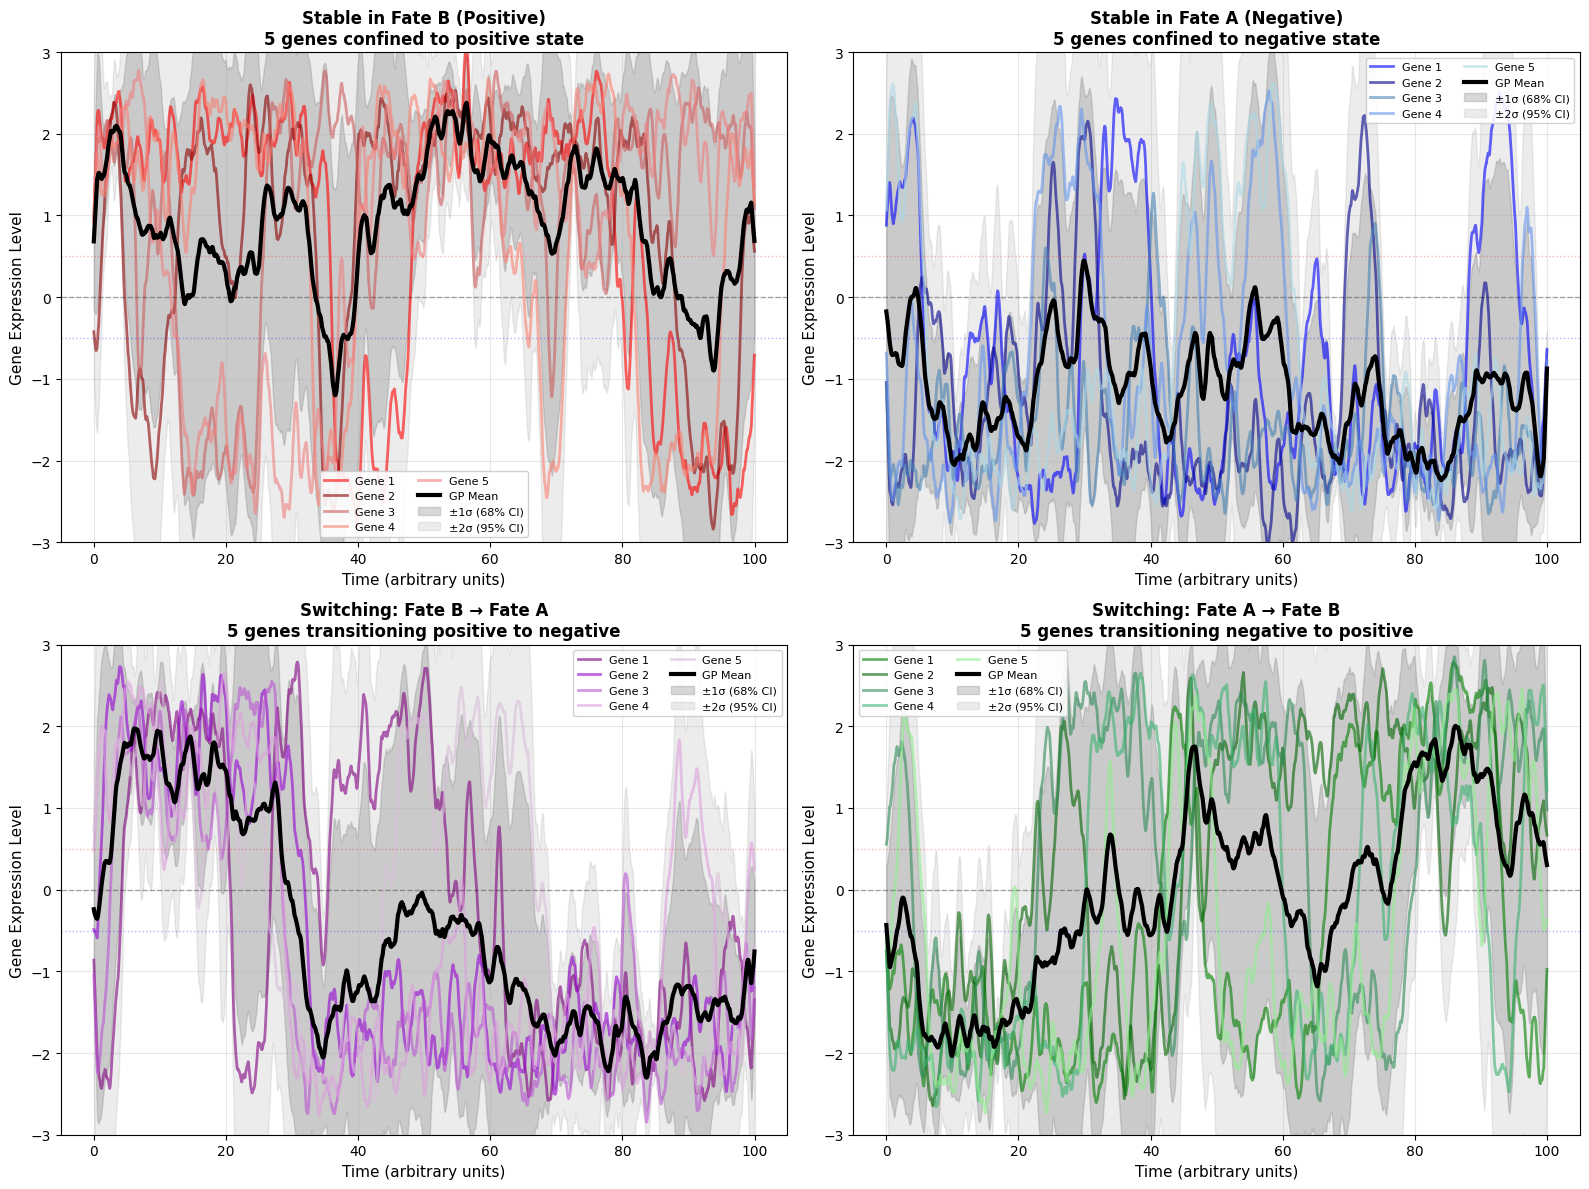


Gaussian Process Statistics:

POSITIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [-1.201, 2.379]
  Average σ: 1.873
  Max σ: 3.418
  Min σ: 0.217

NEGATIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [-2.242, 0.449]
  Average σ: 1.594
  Max σ: 3.483
  Min σ: 0.129

POS_TO_NEG:
  N trajectories: 5
  Mean trajectory range: [-2.301, 1.975]
  Average σ: 1.545
  Max σ: 3.224
  Min σ: 0.095

NEG_TO_POS:
  N trajectories: 5
  Mean trajectory range: [-2.038, 2.006]
  Average σ: 1.887
  Max σ: 3.395
  Min σ: 0.103


In [28]:
import numpy as np
import matplotlib.pyplot as plt

class CellFateModel:
    """Stochastic differential equation model for cell fate decisions"""

    def __init__(self, noise_strength=0.3, dt=0.01):
        self.noise_strength = noise_strength
        self.dt = dt

    def bistable_potential(self, x, a=1.0, b=0.25):
        """Double-well potential: U(x) = -a*x^2/2 + b*x^4/4"""
        return -a * x**2 / 2 + b * x**4 / 4

    def force(self, x, a=1.0, b=0.25):
        """Force derived from potential: F(x) = -dU/dx = a*x - b*x^3"""
        return a * x - b * x**3

    def simulate_1D(self, n_steps, x0=0.0, a=1.0, b=0.25):
        """Simulate 1D Langevin dynamics with Euler-Maruyama method"""
        x = np.zeros(n_steps)
        x[0] = x0

        for i in range(1, n_steps):
            # Deterministic drift
            drift = self.force(x[i-1], a, b) * self.dt
            # Stochastic diffusion
            diffusion = self.noise_strength * np.sqrt(self.dt) * np.random.randn()
            x[i] = x[i-1] + drift + diffusion

        return x


def classify_trajectory_behavior(traj, threshold=0.7):
    """
    Classify trajectory into 4 behavioral categories:
    1. Positive only (Fate B stable)
    2. Negative only (Fate A stable)
    3. Positive to Negative switching
    4. Negative to Positive switching
    """
    # Find initial state (first 20% of trajectory)
    init_period = len(traj) // 5
    initial_state = np.mean(traj[:init_period])

    # Find final state (last 30% of trajectory)
    final_period = int(len(traj) * 0.3)
    final_state = np.mean(traj[-final_period:])

    # Determine dominant behavior based on time spent in each region
    time_positive = np.sum(traj > threshold)
    time_negative = np.sum(traj < -threshold)
    total_time = len(traj)

    # Classification based on initial and final states
    if initial_state > threshold and final_state > threshold:
        # Started positive, ended positive
        if time_positive > 0.6 * total_time:
            return "positive_only"
    elif initial_state < -threshold and final_state < -threshold:
        # Started negative, ended negative
        if time_negative > 0.6 * total_time:
            return "negative_only"
    elif initial_state > threshold and final_state < -threshold:
        # Clear switch from positive to negative
        return "pos_to_neg"
    elif initial_state < -threshold and final_state > threshold:
        # Clear switch from negative to positive
        return "neg_to_pos"

    # Fallback: classify by where trajectory spends most time
    if time_positive > time_negative and time_positive > 0.6 * total_time:
        return "positive_only"
    elif time_negative > time_positive and time_negative > 0.6 * total_time:
        return "negative_only"

    return "ambiguous"


def smooth_trajectory(traj, window_size=50):
    """Apply moving average smoothing to trajectory"""
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(traj, kernel, mode='same')
    return smoothed


def fit_gaussian_process(trajectories, time_points, smooth=True, window_size=50):
    """
    Fit Gaussian Process to a set of trajectories
    Returns mean trajectory and standard deviation
    """
    # Stack trajectories
    traj_array = np.array(trajectories)

    # Apply smoothing if requested
    if smooth:
        smoothed_trajs = []
        for traj in traj_array:
            smoothed_trajs.append(smooth_trajectory(traj, window_size))
        traj_array = np.array(smoothed_trajs)

    # Calculate mean and std (sigma)
    mean_traj = np.mean(traj_array, axis=0)
    std_traj = np.std(traj_array, axis=0)

    return mean_traj, std_traj


def plot_trajectory_classes_with_gp():
    """
    Generate and visualize 4 trajectory classes with Gaussian Process modeling
    """
    model = CellFateModel(noise_strength=1.2, dt=0.01)  # Increased noise for higher std
    n_steps = 10000
    time = np.arange(n_steps) * 0.01

    # Storage for classified trajectories
    trajectory_classes = {
        "positive_only": [],
        "negative_only": [],
        "pos_to_neg": [],
        "neg_to_pos": []
    }

    # Generate many trajectories and classify them
    print("Generating and classifying trajectories...")
    n_attempts = 500  # Increased attempts to find all 4 classes

    # Initial conditions biased toward different fates
    for _ in range(n_attempts):
        # Bias initial conditions to help find different behaviors
        category_target = _ % 4
        if category_target == 0:
            x0 = np.random.uniform(1.0, 2.0)  # Start positive
        elif category_target == 1:
            x0 = np.random.uniform(-2.0, -1.0)  # Start negative
        elif category_target == 2:
            x0 = np.random.uniform(0.8, 1.5)  # Positive, might switch
        else:
            x0 = np.random.uniform(-1.5, -0.8)  # Negative, might switch

        traj = model.simulate_1D(n_steps, x0=x0)
        behavior = classify_trajectory_behavior(traj)

        if behavior in trajectory_classes:
            if len(trajectory_classes[behavior]) < 5:
                trajectory_classes[behavior].append(traj)

    # Print classification results
    for key, trajs in trajectory_classes.items():
        print(f"{key}: {len(trajs)} trajectories found")

    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    titles = {
        "positive_only": "Stable in Fate B (Positive)\n5 genes confined to positive state",
        "negative_only": "Stable in Fate A (Negative)\n5 genes confined to negative state",
        "pos_to_neg": "Switching: Fate B → Fate A\n5 genes transitioning positive to negative",
        "neg_to_pos": "Switching: Fate A → Fate B\n5 genes transitioning negative to positive"
    }

    colors_per_class = {
        "positive_only": ['red', 'darkred', 'indianred', 'salmon', 'lightcoral'],
        "negative_only": ['blue', 'darkblue', 'steelblue', 'cornflowerblue', 'lightblue'],
        "pos_to_neg": ['purple', 'darkviolet', 'mediumorchid', 'plum', 'thistle'],
        "neg_to_pos": ['green', 'darkgreen', 'seagreen', 'mediumseagreen', 'lightgreen']
    }

    for idx, (behavior, trajs) in enumerate(trajectory_classes.items()):
        ax = axes[idx]

        if len(trajs) == 0:
            ax.text(0.5, 0.5, f"No {behavior} trajectories found\n(increase n_attempts)",
                   ha='center', va='center', fontsize=12, transform=ax.transAxes)
            ax.set_title(titles[behavior], fontsize=12, fontweight='bold')
            continue

        colors = colors_per_class[behavior]

        # Plot individual trajectories (5 genes) - smoothed and with reduced wiggle
        for i, traj in enumerate(trajs):
            smoothed_traj = smooth_trajectory(traj, window_size=100)
            ax.plot(time, smoothed_traj, linewidth=2, alpha=0.6,
                   color=colors[i], label=f'Gene {i+1}')

        # Fit and plot Gaussian Process
        if len(trajs) >= 2:
            mean_traj, std_traj = fit_gaussian_process(trajs, time, smooth=True, window_size=100)

            # Amplify standard deviation for better visualization
            std_traj_amplified = std_traj * 1.5

            # Plot GP mean
            ax.plot(time, mean_traj, 'k-', linewidth=3,
                   label='GP Mean', zorder=100)

            # Plot GP confidence intervals (±1σ and ±2σ)
            ax.fill_between(time, mean_traj - std_traj_amplified, mean_traj + std_traj_amplified,
                           alpha=0.3, color='gray', label='±1σ (68% CI)')
            ax.fill_between(time, mean_traj - 2*std_traj_amplified, mean_traj + 2*std_traj_amplified,
                           alpha=0.15, color='gray', label='±2σ (95% CI)')

        # Add reference lines
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
        ax.axhline(y=0.5, color='red', linestyle=':', alpha=0.3, linewidth=1)
        ax.axhline(y=-0.5, color='blue', linestyle=':', alpha=0.3, linewidth=1)

        # Formatting
        ax.set_xlabel('Time (arbitrary units)', fontsize=11)
        ax.set_ylabel('Gene Expression Level', fontsize=11)
        ax.set_title(titles[behavior], fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=8, framealpha=0.9, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-3, 3)

    plt.tight_layout()
    plt.show()

    # Print GP statistics
    print("\n" + "="*60)
    print("Gaussian Process Statistics:")
    print("="*60)
    for behavior, trajs in trajectory_classes.items():
        if len(trajs) >= 2:
            mean_traj, std_traj = fit_gaussian_process(trajs, time, smooth=True, window_size=100)
            std_traj_amplified = std_traj * 1.5
            print(f"\n{behavior.upper()}:")
            print(f"  N trajectories: {len(trajs)}")
            print(f"  Mean trajectory range: [{mean_traj.min():.3f}, {mean_traj.max():.3f}]")
            print(f"  Average σ: {np.mean(std_traj_amplified):.3f}")
            print(f"  Max σ: {np.max(std_traj_amplified):.3f}")
            print(f"  Min σ: {np.min(std_traj_amplified):.3f}")


# Run the analysis

Generating and classifying trajectories...
positive_only: 5 trajectories found
negative_only: 5 trajectories found
pos_to_neg: 5 trajectories found
neg_to_pos: 5 trajectories found


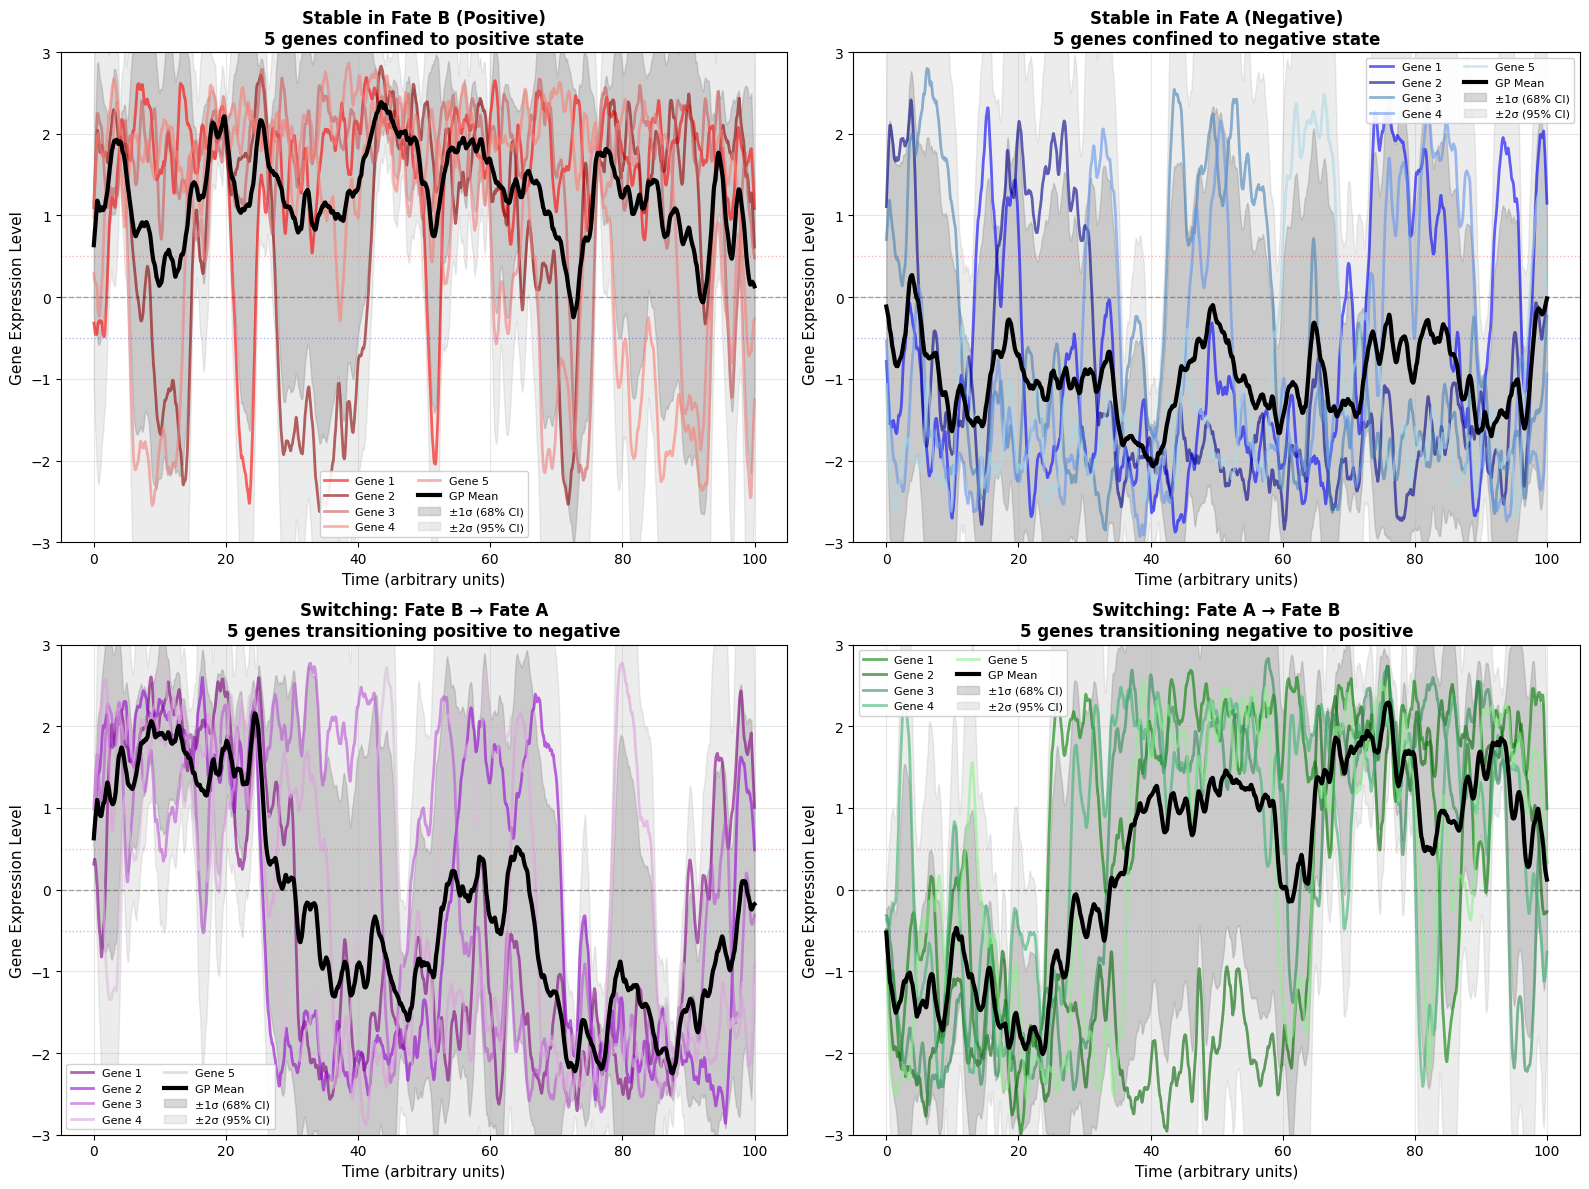


Gaussian Process Statistics:

POSITIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [-0.246, 2.388]
  Average σ: 1.559
  Max σ: 2.913
  Min σ: 0.074

NEGATIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [-2.071, 0.271]
  Average σ: 1.912
  Max σ: 2.931
  Min σ: 0.395

POS_TO_NEG:
  N trajectories: 5
  Mean trajectory range: [-2.248, 2.160]
  Average σ: 1.639
  Max σ: 2.923
  Min σ: 0.126

NEG_TO_POS:
  N trajectories: 5
  Mean trajectory range: [-2.012, 2.291]
  Average σ: 1.687
  Max σ: 3.013
  Min σ: 0.261


In [30]:
plot_trajectory_classes_with_gp()

Generating and classifying trajectories...
positive_only: 5 trajectories found
negative_only: 5 trajectories found
pos_to_neg: 5 trajectories found
neg_to_pos: 5 trajectories found


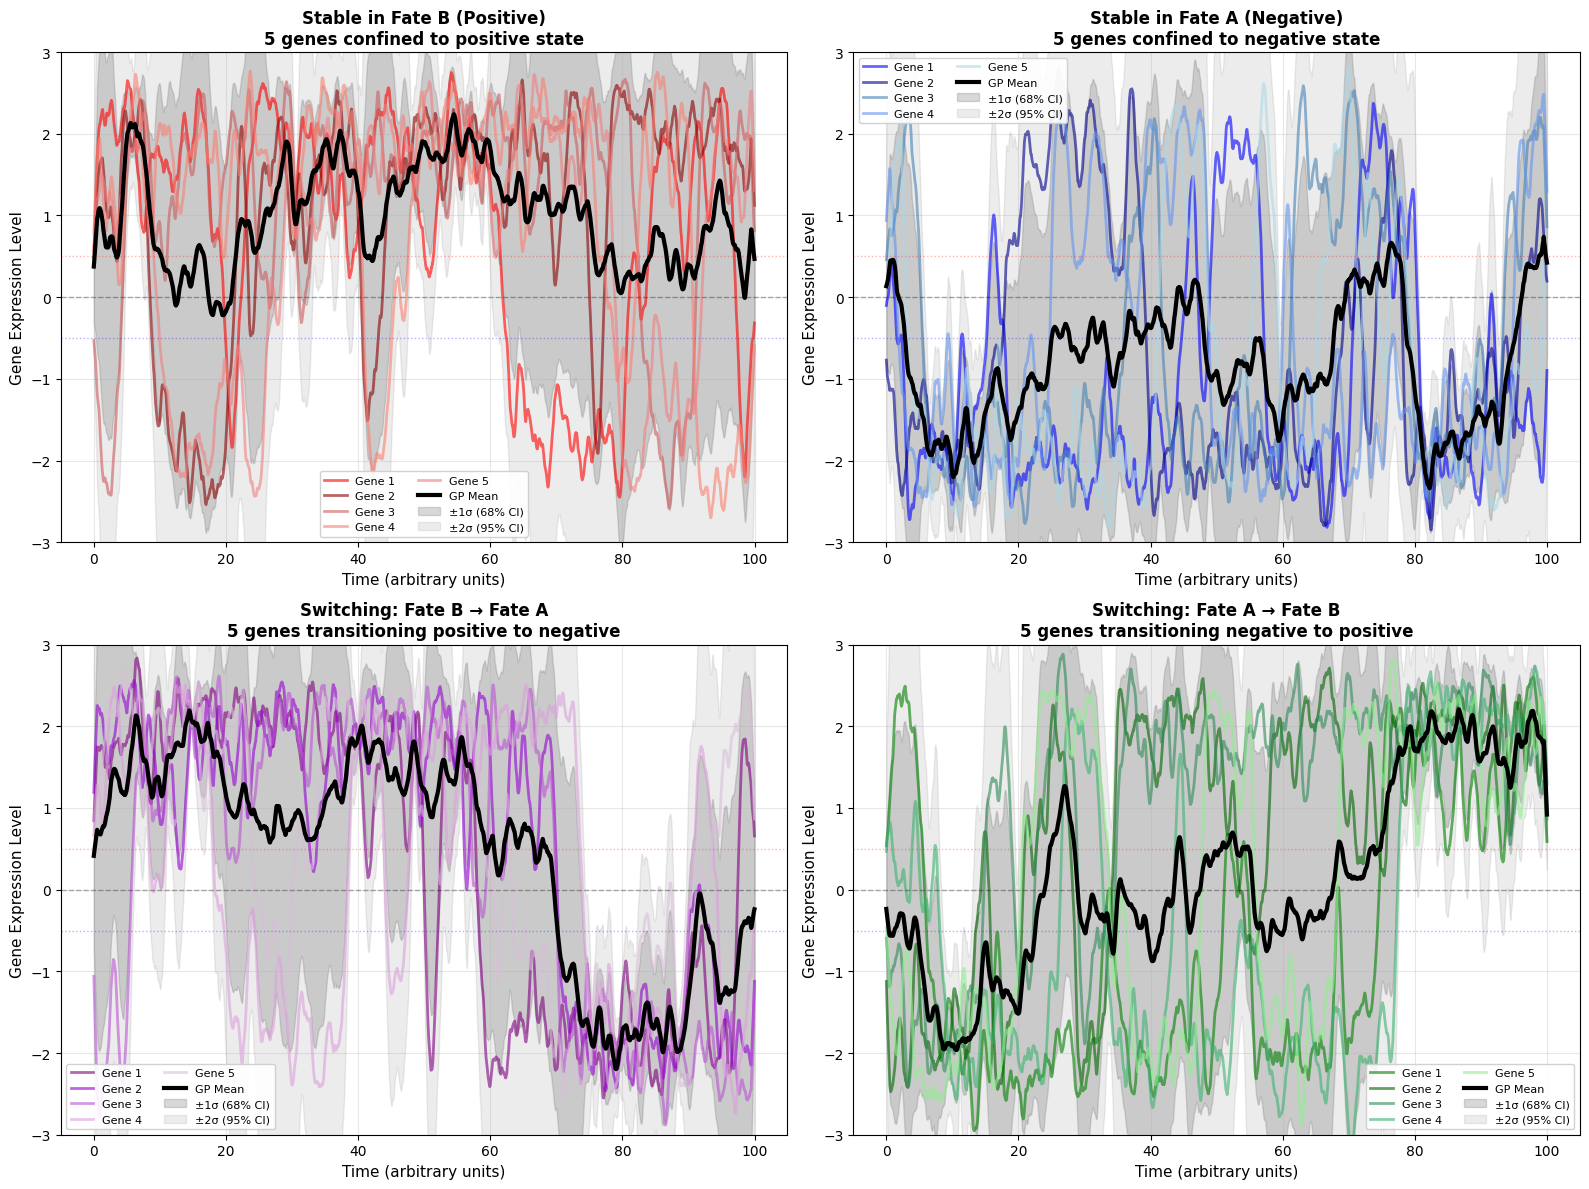


Gaussian Process Statistics:

POSITIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [-0.222, 2.240]
  Average σ: 1.763
  Max σ: 3.230
  Min σ: 0.198

NEGATIVE_ONLY:
  N trajectories: 5
  Mean trajectory range: [-2.340, 0.739]
  Average σ: 1.783
  Max σ: 3.293
  Min σ: 0.245

POS_TO_NEG:
  N trajectories: 5
  Mean trajectory range: [-2.196, 2.195]
  Average σ: 1.541
  Max σ: 3.059
  Min σ: 0.028

NEG_TO_POS:
  N trajectories: 5
  Mean trajectory range: [-1.963, 2.209]
  Average σ: 1.888
  Max σ: 3.386
  Min σ: 0.224


In [33]:
plot_trajectory_classes_with_gp()